# Explore here

In [56]:
import pandas as pd
from utils import db_connect
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import RobustScaler

In [57]:
# Establecer la conexión a la base de datos
engine = db_connect()

# Verificar si la conexión es exitosa
#if engine:
    #print("Conexión exitosa")

# Consultar la tabla en la base de datos y crear un DataFrame
data = pd.read_sql_table('tabla seguro', engine)

pd.set_option('display.max_columns', None)  # muestra todas las columnas del dataframe
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [58]:
data.shape

(1338, 7)

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [60]:
data.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [61]:
data.isnull().any().any()

False

In [62]:
data.duplicated().sum()
fila_duplicada = data[data.duplicated()]
fila_duplicada

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [63]:
data = data.drop_duplicates().reset_index(drop = True)
data.duplicated().sum()

0

In [64]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


In [65]:
# Usamos pd.factorize para codificar las columnas para preservar el orden de las categorias, 
# a diferencia de LabelEncoder, que usa menos memoria pero no mantiene el orden de las categorias.

# Nos decidimos por esta forma ya que tenemos pocas categorías distintas, y pd.factorize
# devuelve tanto los códigos numéricos como las categorías originales, lo que puede ser útil para futuros análisis.

data["sex_num"] = pd.factorize(data["sex"])[0]
data["smoker_num"] = pd.factorize(data["smoker"])[0]
data["region_num"] = pd.factorize(data["region"])[0]

data.head()



,age,sex,bmi,children,smoker,region,charges,sex_num,smoker_num,region_num
0,19,female,27.900,0,yes,southwest,16884.92400,0,0,0
1,18,male,33.770,1,no,southeast,1725.55230,1,1,1
2,28,male,33.000,3,no,southeast,4449.46200,1,1,1
3,33,male,22.705,0,no,northwest,21984.47061,1,1,2
4,32,male,28.880,0,no,northwest,3866.85520,1,1,2


In [66]:
data_num = data[["age", "bmi", "children", "sex_num", "smoker_num", "region_num", "charges"]].copy() # .copy() para crear dataframe independiente al original
data_num.corr()

# Vemos que apenas hay correlacion entre la región y la prima de seguro, algo normal,
#  * ya que si bien una region puede tener una tendencia hacia una característica influyente mayor que la otra, no tiene que verse reflejada
#  * en todos los sujetos de dicha zona, por lo que sería injusto que, por ejemplo, su prima aumentase por proceder de una zona con mayor 
#  * índice de fumadores, a pesar de que el sujeto concreto no haya fumado en su vida.
# Lo mismo ocurre en relación al sexo.

# Por tanto, eliminaremos las variables.

,age,bmi,children,sex_num,smoker_num,region_num,charges
age,1.000000,0.109344,0.041536,-0.019814,0.025587,-0.001626,0.298308
bmi,0.109344,1.000000,0.012755,0.046397,-0.003746,-0.157574,0.198401
children,0.041536,0.012755,1.000000,0.017848,-0.007331,-0.016258,0.067389
sex_num,-0.019814,0.046397,0.017848,1.000000,-0.076596,-0.004936,0.058044
smoker_num,0.025587,-0.003746,-0.007331,-0.076596,1.000000,-0.002358,-0.787234
region_num,-0.001626,-0.157574,-0.016258,-0.004936,-0.002358,1.000000,0.006547
charges,0.298308,0.198401,0.067389,0.058044,-0.787234,0.006547,1.000000


Edad y Costos: Hay una correlación positiva moderada entre la edad y los costos médicos. Esto sugiere que a medida que la edad aumenta, es probable que los costos médicos también aumenten, lo cual es razonable ya que las personas mayores tienden a tener más problemas de salud y pueden requerir más atención médica.

IMC (BMI) y Costos: Existe una correlación positiva leve entre el índice de masa corporal (IMC) y los costos médicos. Esto indica que las personas con un IMC más alto tienden a tener costos médicos ligeramente más altos. Sin embargo, la correlación no es muy fuerte.

Fumadores y Costos: La correlación entre el hecho de ser fumador y los costos médicos es bastante alta y negativa. Esto sugiere que los fumadores tienden a tener costos médicos mucho más altos en comparación con los no fumadores. Esta es una observación significativa y coherente con la literatura médica, ya que el hábito de fumar está asociado con una variedad de problemas de salud.

Región y Costos: La correlación entre la región y los costos médicos es muy baja, lo que indica que la región donde reside una persona tiene una influencia mínima en sus costos médicos.

Sexo y Costos: La correlación entre el sexo y los costos médicos es muy baja, lo que indica que no hay una relación significativa entre el sexo de una persona y sus costos médicos.

En resumen, la edad, el IMC y el hábito de fumar parecen ser los factores más influyentes en los costos médicos, según esta matriz de correlación.

In [67]:
data.drop(['region', 'region_num', 'sex', 'sex_num'], axis=1, inplace=True)
data_num.drop(['region_num', 'sex_num'], axis=1, inplace=True)
data.head()

,age,bmi,children,smoker,charges,smoker_num
0,19,27.900,0,yes,16884.92400,0
1,18,33.770,1,no,1725.55230,1
2,28,33.000,3,no,4449.46200,1
3,33,22.705,0,no,21984.47061,1
4,32,28.880,0,no,3866.85520,1


In [68]:
#  Buscar valores atípicos (y ver si corresponderia tambien consultar la influencia), antes de elegir el método de escalado

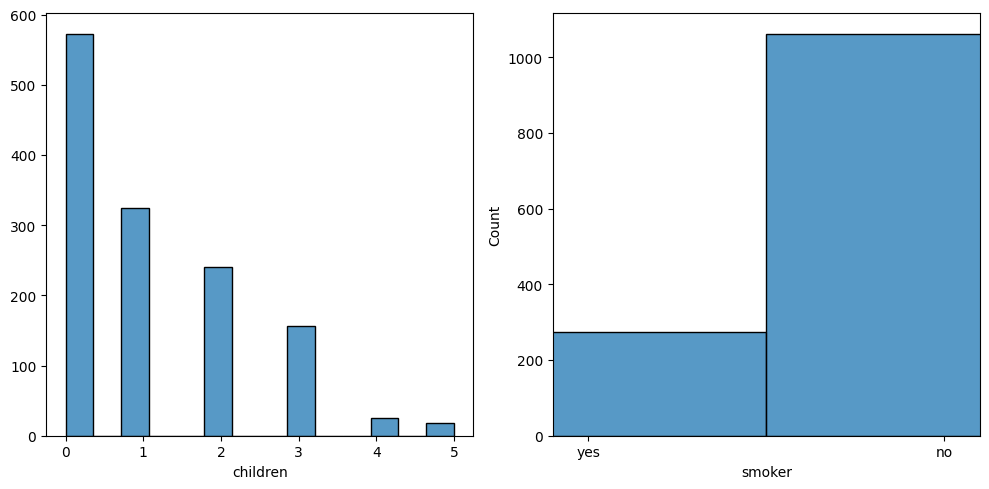

In [69]:
# Análisis ded variables univariantes (categóricas)

fig, axis = plt.subplots(1, 2, figsize = (10, 5))

# Crear un histograma múltiple
sns.histplot(ax = axis[0], data = data, x = "children").set(ylabel = None)
sns.histplot(ax = axis[1], data = data, x = "smoker").set_xlim(-0.1, 1.1)


# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

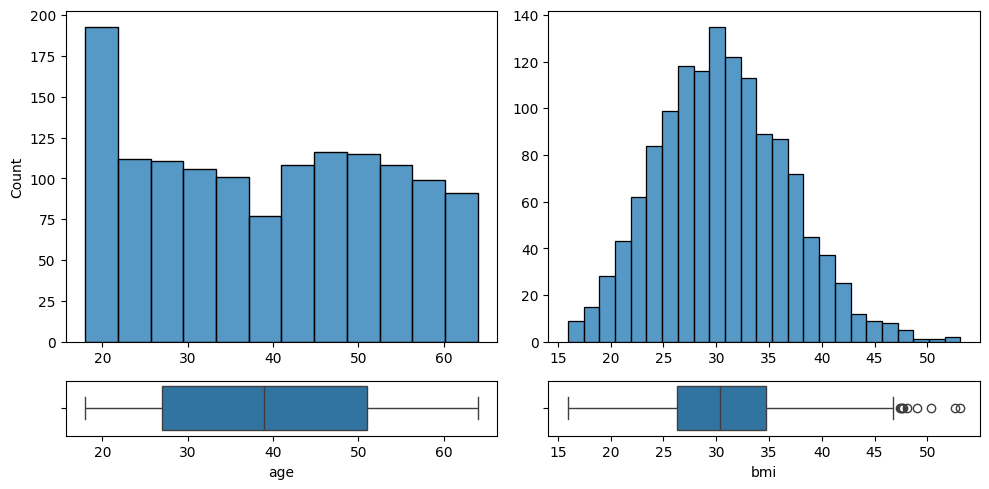

In [70]:
# Análisis sobre variables numéricas

fig, axis = plt.subplots(2, 2, figsize = (10, 5), gridspec_kw={'height_ratios': [6, 1]})

# Crear una figura múltiple con histogramas y diagramas de caja
sns.histplot(ax = axis[0, 0], data = data, x = "age").set(xlabel = None)
sns.boxplot(ax = axis[1, 0], data = data, x = "age")
sns.histplot(ax = axis[0, 1], data = data, x = "bmi").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = data, x = "bmi")

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

<Axes: xlabel='charges'>

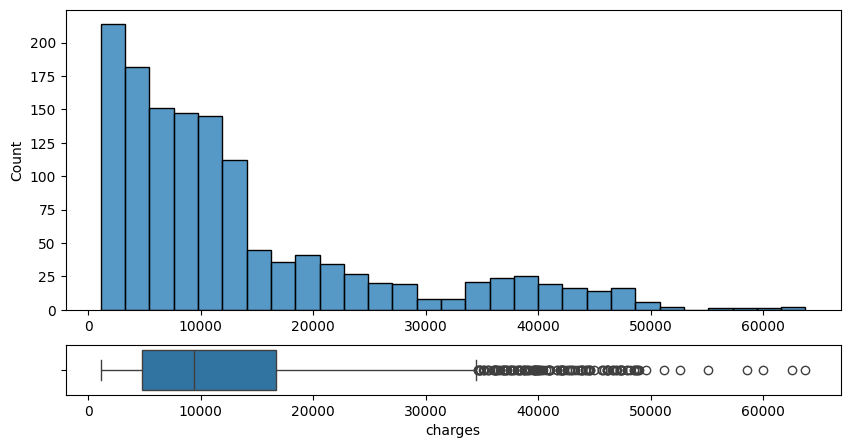

In [71]:
fig, axis = plt.subplots(2, 1, figsize = (10, 5), gridspec_kw={'height_ratios': [6, 1]})

# Crear una figura múltiple con histogramas y diagramas de caja
sns.histplot(ax = axis[0], data = data, x = "charges").set(xlabel = None)
sns.boxplot(ax = axis[1], data = data, x = "charges")

<Axes: xlabel='charges_log'>

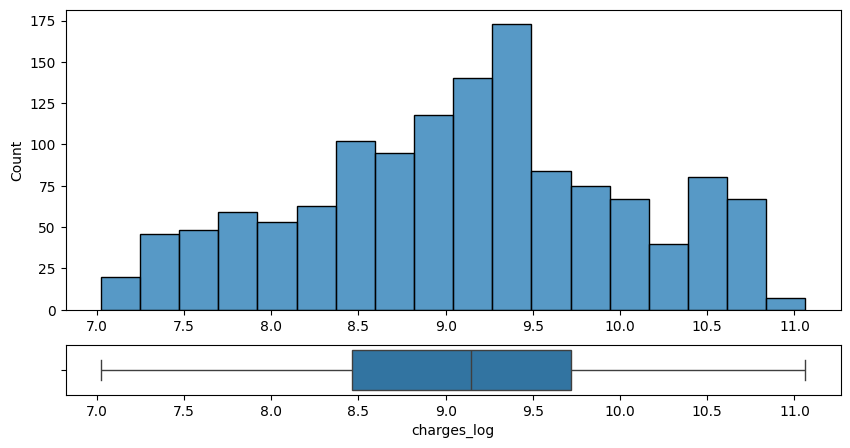

In [72]:
data['charges_log'] = np.log(data.charges)

fig, axis = plt.subplots(2, 1, figsize = (10, 5), gridspec_kw={'height_ratios': [6, 1]})

# Crear una figura múltiple con histogramas y diagramas de caja
sns.histplot(ax = axis[0], data = data, x = "charges_log").set(xlabel = None)
sns.boxplot(ax = axis[1], data = data, x = "charges_log")

In [73]:
data.head()

,age,bmi,children,smoker,charges,smoker_num,charges_log
0,19,27.900,0,yes,16884.92400,0,9.734176
1,18,33.770,1,no,1725.55230,1,7.453302
2,28,33.000,3,no,4449.46200,1,8.400538
3,33,22.705,0,no,21984.47061,1,9.998092
4,32,28.880,0,no,3866.85520,1,8.260197


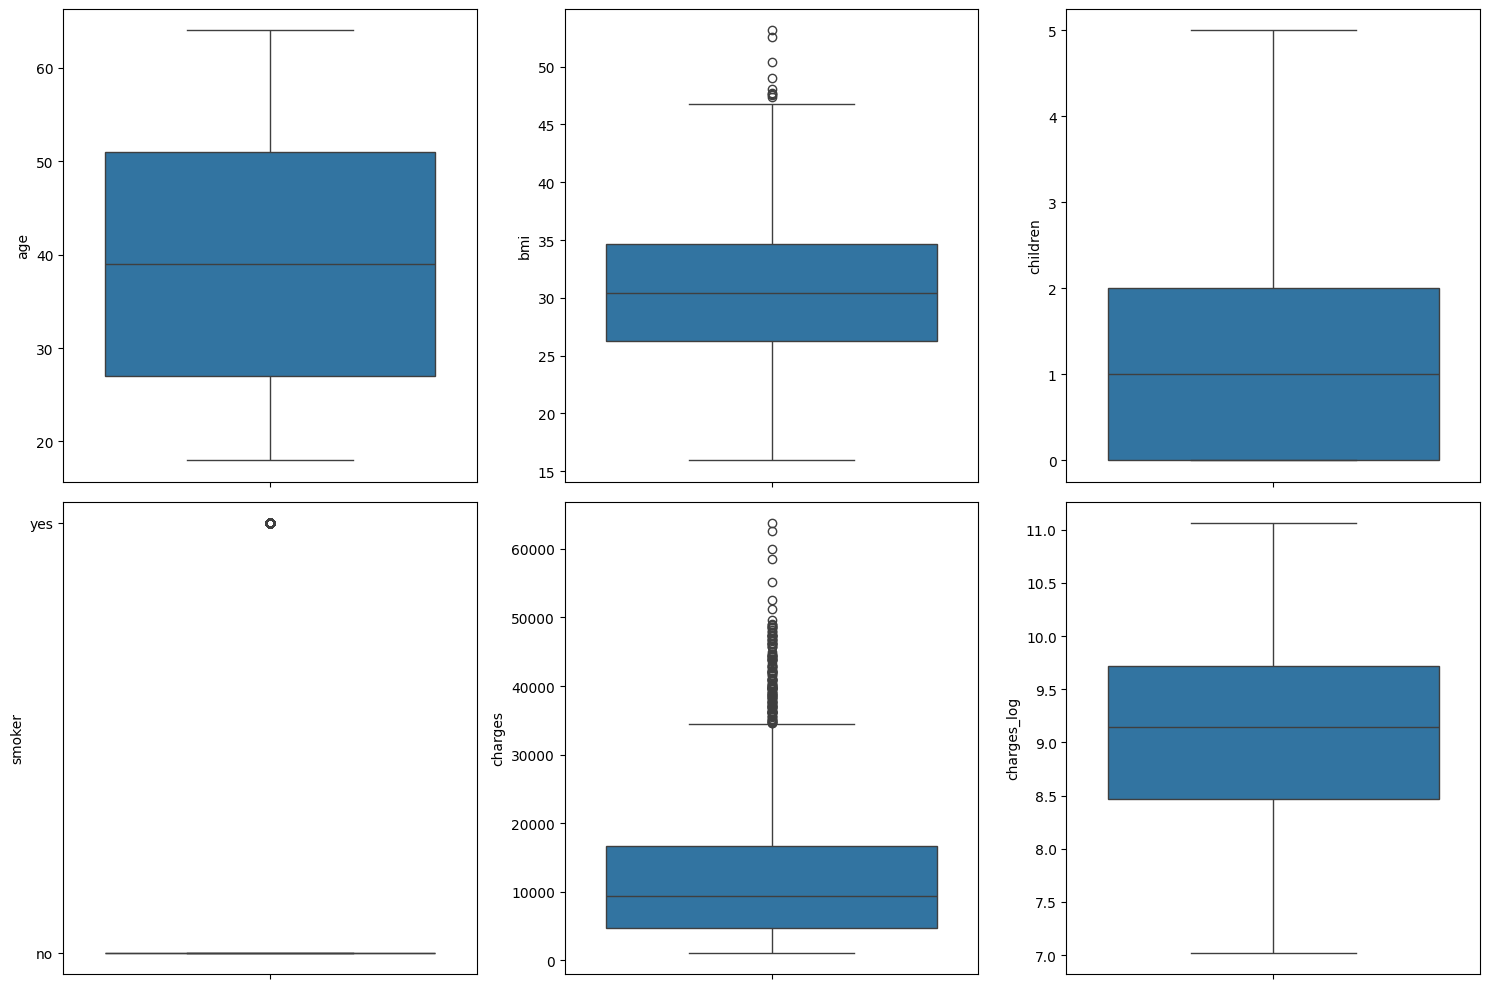

In [74]:
fig, axis = plt.subplots(2, 3, figsize = (15, 10))

sns.boxplot(ax = axis[0, 0], data = data, y = "age")
sns.boxplot(ax = axis[0, 1], data = data, y = "bmi")
sns.boxplot(ax = axis[0, 2], data = data, y = "children")
sns.boxplot(ax = axis[1, 0], data = data, y = "smoker")
sns.boxplot(ax = axis[1, 1], data = data, y = "charges")
sns.boxplot(ax = axis[1, 2], data = data, y = "charges_log")


plt.tight_layout()

plt.show()

In [75]:
data[['bmi', 'charges', 'charges_log']].describe()

,bmi,charges,charges_log
count,1337.000000,1337.000000,1337.000000
mean,30.663452,13279.121487,9.099928
std,6.100468,12110.359656,0.918699
min,15.960000,1121.873900,7.022756
25%,26.290000,4746.344000,8.465130
50%,30.400000,9386.161300,9.146992
75%,34.700000,16657.717450,9.720629
max,53.130000,63770.428010,11.063045


In [76]:
bmi_stats = data['bmi'].describe()

bmi_iqr = bmi_stats["75%"] - bmi_stats["25%"]
upper_limit = bmi_stats["75%"] + 1.5 * bmi_iqr
lower_limit = bmi_stats["25%"] - 1.5 * bmi_iqr

print(f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_limit, 2)} y {round(lower_limit, 2)}, con un rango intercuartílico de {round(bmi_iqr, 2)}")

Los límites superior e inferior para la búsqueda de outliers son 47.32 y 13.67, con un rango intercuartílico de 8.41


In [77]:
total = (data['bmi'] > 47).sum()
print(f"{((data['bmi'] > 47).sum()) / len(data['bmi']) * 100}%")


0.6731488406881078%


In [78]:
data[data["bmi"] > 47]

# Podríamos eliminar los outlayers de bmi porque suponen un porcentaje muy pequeño, pero sumado al análisis univariante anterior,
# existe una implicación entre el precio del seguro y el índice de masa corporal, por lo que mantenemos los valores atípicos

,age,bmi,children,smoker,charges,smoker_num,charges_log
116,58,49.06,0,no,11381.32540,1,9.339729
286,46,48.07,2,no,9432.92530,1,9.151962
401,47,47.52,1,no,8083.91980,1,8.997632
543,54,47.41,0,yes,63770.42801,0,11.063045
846,23,50.38,1,no,2438.05520,1,7.798956
859,37,47.60,2,yes,46113.51100,0,10.738861
1046,22,52.58,1,yes,44501.39820,0,10.703276
1087,52,47.74,1,no,9748.91060,1,9.184911
1316,18,53.13,0,no,1163.46270,1,7.059156


In [79]:
data_num['charges_log'] = np.log(data_num.charges)
data_num.head()

,age,bmi,children,smoker_num,charges,charges_log
0,19,27.900,0,0,16884.92400,9.734176
1,18,33.770,1,1,1725.55230,7.453302
2,28,33.000,3,1,4449.46200,8.400538
3,33,22.705,0,1,21984.47061,9.998092
4,32,28.880,0,1,3866.85520,8.260197


In [80]:
# Variables independientes/dependiente
X = data_num.drop(['charges', 'charges_log'], axis=1)
y = data_num['charges_log']

# Ajusta el modelo
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance

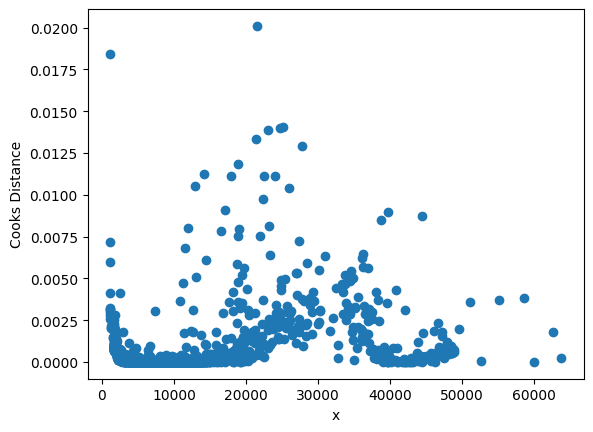

In [81]:
plt.scatter(data_num.charges, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

Si al calcular y graficar la distancia de Cook obtienes un scatter plot que parece una nube dispersa en lugar de una línea alrededor del cero con algunos puntos fuera, significa que no hay puntos de datos particularmente influyentes en tu modelo de regresión. En otras palabras, no hay valores atípicos o puntos que tengan un impacto desproporcionado en los coeficientes de regresión del modelo.

Cuando la distancia de Cook produce una dispersión difusa en lugar de puntos claramente fuera de la línea, puede haber varias razones:

No hay valores atípicos influyentes: En algunos conjuntos de datos, todos los puntos pueden tener una influencia similar en el modelo, lo que resulta en una dispersión uniforme alrededor del cero en el gráfico de distancia de Cook. Esto sugiere que no hay valores atípicos o puntos influyentes que distorsionen significativamente los resultados del modelo.

Robustez del modelo: Algunos modelos de regresión pueden ser inherentemente más robustos ante valores atípicos que otros. Si tu modelo es robusto o si has utilizado técnicas de estimación robustas, es menos probable que los valores atípicos influyan en gran medida en los resultados.

Bajo poder para detectar valores atípicos: En conjuntos de datos pequeños o con pocos predictores, puede ser más difícil detectar valores atípicos utilizando la distancia de Cook. En tales casos, la capacidad del análisis para identificar valores atípicos puede verse limitada.

En resumen, una dispersión difusa en el gráfico de distancia de Cook sugiere que tu modelo de regresión puede ser robusto y que no hay puntos de datos que tengan un impacto desproporcionado en los resultados del modelo. Esto puede ser una señal positiva en términos de la calidad y la fiabilidad del modelo.

In [82]:
out = np.where(cooks_distance[0]>0.0175)
d_out = data_num.iloc[out]

# A pesar de que nustro análisis de cook nos dio una 'nube', si podemos observar dos valores claramente por encima.
# Ambos sujetos son muy jovenes, sin niños y no fumadores.

# Teniendo en cuenta nos basamos en seguros, la juventud suele influír positivamente, pero si es muy joven puede ocurrir lo contrario,
# * ya que las compañias de seguros suelen tener en cuenta la mayor temeridad e irresponsabilidad en los sujetos más jovenes.

# Vemos que el sujeto 1316, tiene el mínimo de edad, pero es el máximo del conjuto en cuanto a bmi, muy por encima de la media, sin embargo,
# * tiene una cuota más barata. Esto puede deberse a un físico anormalmente trabajado, lo que tanto por génetica como por ejercicio, se puede traducir
# * en una salud mejor, y por tanto paga menos.

# El sujeto 1026, aunque a priori la edad le favorecería, ya que es joven pero ya pasa los 20 años, tiene un bmi muy bajo, casi al mínimo,
# * y muy por debajo de la media y del percentil 25%. De esto se deduce que su forma física no es óptima, y por eso su seguro es más caro que es de su análogo.

# Por tanto, como estamos modelizando, eliminaremos estas dos filas de nuestros datos, ya que son sujetos "poco normativos" y que por tanto
# * no representan al grueso de la poblacion, además de que tienen una influencia desproporcionada en el modelo.

In [83]:
data_num.drop(d_out.index, axis=0, inplace=True)
data_num.reset_index(drop=True, inplace=True)
data_num.head()

,age,bmi,children,smoker_num,charges,charges_log
0,19,27.900,0,0,16884.92400,9.734176
1,18,33.770,1,1,1725.55230,7.453302
2,28,33.000,3,1,4449.46200,8.400538
3,33,22.705,0,1,21984.47061,9.998092
4,32,28.880,0,1,3866.85520,8.260197


In [84]:
data.isnull().any().any()

False

In [85]:
data_num.apply(lambda x: x.skew())

age            0.052713
bmi            0.260822
children       0.935500
smoker_num    -1.461269
charges        1.516569
charges_log   -0.085610
dtype: float64

In [86]:
# La windsorización puede ser útil para suavizar los efectos de los valores atípicos en tus datos
# y mejorar la capacidad predictiva de tu modelo de regresión lineal.

# Seleccionamos las columnas no binarias
binarias = data_num[['smoker_num']]
data_wind = data_num.drop(binarias, axis=1)

# Función para calcular IQR y aplicar winsorización
def winsorize_column(column, lower, upper):
    q1 = column.quantile(lower)
    q3 = column.quantile(upper)
    iqr_value = q3-q1
    lower_bound = q1 - 1.5 * iqr_value
    upper_bound = q3 + 1.5 * iqr_value
    column = column.clip(lower=lower_bound, upper=upper_bound)
    return column

# Calcular el IQR y aplicar winsorización a cada columna
for column in data_wind.columns:
    data_wind[column] = winsorize_column(data_wind[column], 0.25, 0.75)

In [87]:
data_wind.apply(lambda x: x.skew())

age            0.052713
bmi            0.226627
children       0.935500
charges        1.082660
charges_log   -0.085610
dtype: float64

In [ ]:
data_p = pd.concat([data_wind, binarias], axis=1)

In [93]:
data_p.head()

,age,bmi,children,charges,charges_log,smoker_num
0,19,27.900,0,16884.92400,9.734176,0
1,18,33.770,1,1725.55230,7.453302,1
2,28,33.000,3,4449.46200,8.400538,1
3,33,22.705,0,21984.47061,9.998092,1
4,32,28.880,0,3866.85520,8.260197,1


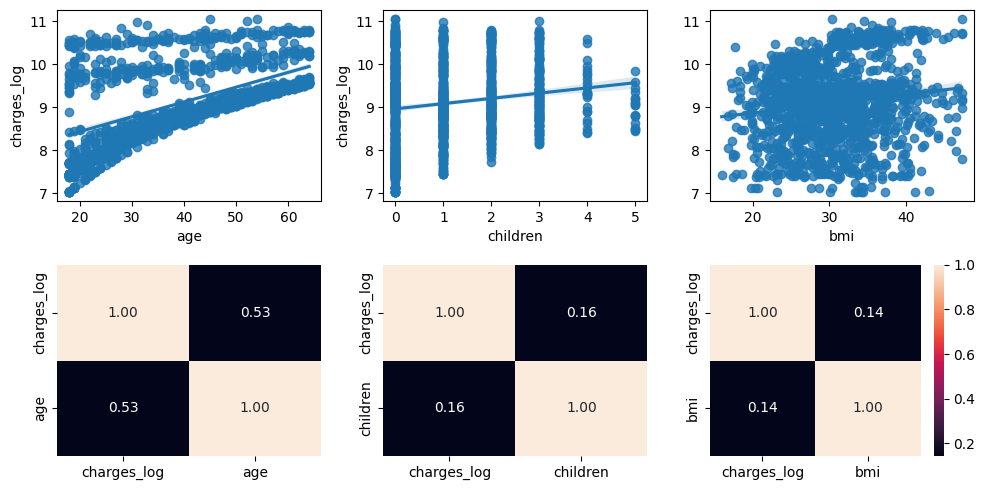

In [109]:
fig, axis = plt.subplots(2, 3, figsize = (10, 5))

# Crear un diagrama de dispersión múltiple
sns.regplot(ax = axis[0, 0], data = data_p, x = "age", y = "charges_log")
sns.heatmap(data_p[["charges_log", "age"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)
sns.regplot(ax = axis[0, 1], data = data_p, x = "children", y = "charges_log")
sns.heatmap(data_p[["charges_log", "children"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1], cbar = False)
sns.regplot(ax = axis[0, 2], data = data_p, x = "bmi", y = "charges_log").set(ylabel=None)
sns.heatmap(data_p[["charges_log", "bmi"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 2])

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

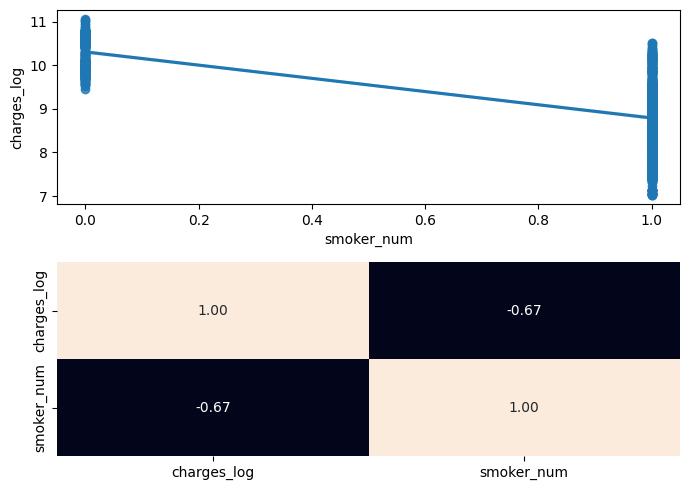

In [102]:
fig, axis = plt.subplots(2, 1, figsize = (7, 5))

# Crear un diagrama de dispersión múltiple
sns.regplot(ax = axis[0], data = data, x = "smoker_num", y = "charges_log")
sns.heatmap(data[["charges_log", "smoker_num"]].corr(), annot = True, fmt = ".2f", ax = axis[1], cbar = False)


# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

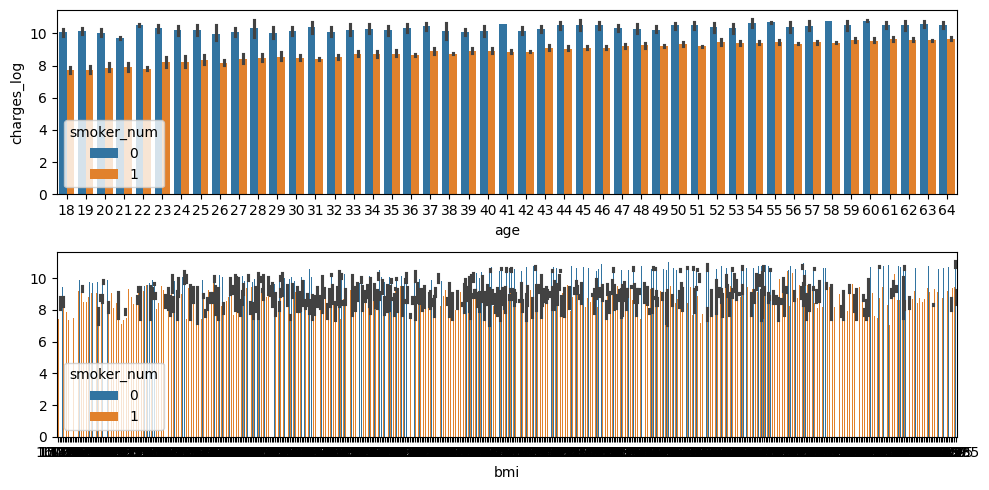

In [110]:
fig, axis = plt.subplots(2, 1, figsize = (10, 5))

sns.barplot(ax = axis[0], data = data_p, x = "age", y = "charges_log", hue = "smoker_num")
sns.barplot(ax = axis[1], data = data_p, x = "bmi", y = "charges_log", hue = "smoker_num").set(ylabel = None)

plt.tight_layout()

plt.show()

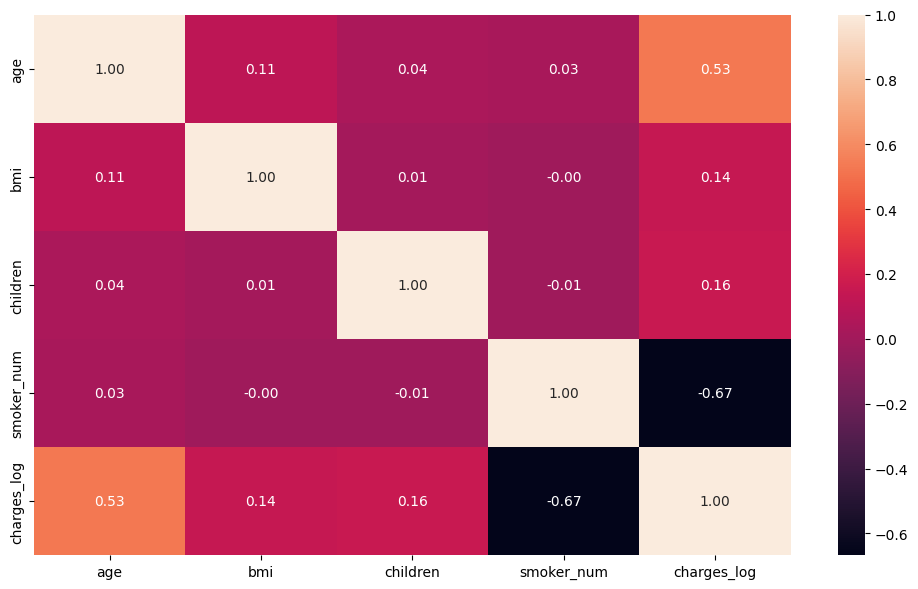

In [112]:
fig, axis = plt.subplots(figsize = (10, 6))

sns.heatmap(data_p[["age", "bmi", "children", "smoker_num", "charges_log"]].corr(), annot = True, fmt = ".2f")

plt.tight_layout()

plt.show()

# En principio observamos una correlacion bastante fuerte entre la edad y ser fumador con el precio del seguro.
# El índice de masa corporal y el numero de niños a cargo no parecen influír demasiado en el precio.

In [113]:
data_p[['age', 'children']].corr()

,age,children
age,1.000000,0.039798
children,0.039798,1.000000


In [ ]:
# Categorización del IMC - hay que tener en cuenta que el imc no tiene en cuenta la composición corporal, es decir,
# si tu peso se debe a un mayor contenido en grasa o en músculo, cosa relevante ya que el músculo pesa más que la grasa, y un mayor porcentaje de
# musculo se relaciona con una salud más robusta, por lo que un imc muy alto puede deberse tanto a una situación de obesidad, como a un
# físico muy musculado. 

# De hecho, como se mencionó anteriormente, el músculo pesa más que la grasa, por lo que a mayor desarrollo de la musculatura, el
# efecto en el peso, y por tanto el IMC, va a impactar más que en el caso de la acumulación de grasa.

# Esto explica la baja correlacion entre el IMC y la prima de seguro, y por tanto, decidimos no categorizar el IMC según la tabla de la OMS,
# ya que no son datos de valor. 

# Por ejemplo, en los valores atípicos observados anteriormente, nos encontrabamos con un sijeto de 18 años con un IMC de 50, lo cual es muy elevado.
# Si nos guíasemos por la tabla de la OMS, este sujeto se categorizaria como "Obesidad clase III", y sin embargo, observabamos 
# que tenía una prima de seguro más baja que el otro sujeto atípico, que se encontraba en el límite del 'peso normal', siendo la variable 
# edad poco relevante ya que solo se llevaban 5 años de diferencia y ambos eran muy jóvenes, por lo que podríamos deducir que el alto IMC
# del sujeto de 18 años se debe a una musculatura más desarrollada y no a una situación de obesidad severa.

In [89]:
# Escalado de valores

escalar_variables = ["age", "bmi", "children", "smoker_num", "charges"]